In [379]:
from mendeleev import element
import sys
import pandas as pd

import os
import jax.numpy as np
import jax.numpy as jnp
import pickle
from typing import Callable, Union, Tuple, Any
from jax.api import grad, vmap, eval_shape
from jax.abstract_arrays import ShapedArray

import jax
from jax import lax

from jax.api import jit, vmap, grad
from jax.experimental import stax
from jax.experimental import optimizers
from jax_md import space, dataclasses, quantity, partition, smap, util

# TODO: Re-enable x64 mode after XLA bug fix.
# from jax.config import config ; config.update('jax_enable_x64', True)
import warnings
warnings.simplefilter('ignore')
import numpy as onp
from typing import Callable, Tuple, Dict, Any, Optional
from jax import random

from jax_md import energy, space, simulate, quantity

# Plotting.

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
from IPython import display
from functools import partial

sys.path.append("../") # go to parent dir


import pyanitools as pya

Array = util.Array
f32 = util.f32
f64 = util.f64

DisplacementFn = space.DisplacementFn
MetricFn = space.MetricFn
Box = space.Box

# Set the HDF5 file containing the data
hdf5file = 'ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)
counter = 0
dta = []
# Print the species of the data set one by one
for data in adl:

    # Extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']
    positions = jax.device_put(X)
    energies = jax.device_put(E)
    print(len(X))
    # Print the data
    print("Path:   ", P)
    print("  Smiles:      ","".join(sm))
    print("  Symbols:     ", S)
    print("  Coordinates: ", X)
    print("  Energies:    ", E, "\n")
    
    periods = []   
    r = []
    for sym in S:
        periods.append(element(sym).period)
        r.append(element(sym).atomic_radius)
        
    dta.append([periods, X, E, r])

# Closes the H5 data file
adl.cleanup()

5400
Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  [[[-0.0034502   0.01017081  0.01938033]
  [-0.7954868   0.5766599  -0.5472012 ]
  [-0.39378393 -0.97992676  0.2722862 ]
  [ 0.6344988   0.4473651   0.93568736]
  [ 0.59581804 -0.16517928 -0.8915708 ]]

 [[ 0.00311385 -0.02007288  0.00282224]
  [-0.78331304  0.7921426  -0.26027855]
  [-0.45410746 -1.0295471   0.31240797]
  [ 0.44713658  0.63571125  0.76770777]
  [ 0.7531731  -0.1592813  -0.85348135]]

 [[-0.0177954  -0.02192003 -0.01129478]
  [-0.73020756  0.6824338  -0.30819252]
  [-0.382202   -0.86773723  0.3822439 ]
  [ 0.56933683  0.50535196  0.80417496]
  [ 0.75492465 -0.05902938 -0.74378157]]

 ...

 [[ 0.00874467  0.00214323 -0.00896647]
  [-0.85504687  0.6273413  -0.26081228]
  [-0.47105345 -0.9456285   0.3252177 ]
  [ 0.48764503  0.50858426  0.85931367]
  [ 0.7342992  -0.21579494 -0.816997  ]]

 [[ 0.00265332  0.01679167  0.02970096]
  [-0.7641574   0

In [380]:
def add_periods(dt):
    for mol_type in dt:
        layer = onp.zeros((mol_type[1].shape[0],mol_type[1].shape[1], 1))
        mol_type[1] = onp.concatenate((mol_type[1], layer), axis=2)

    for j in range(len(dt)):

        trans = onp.array(dt[j][3])
        trans = onp.atleast_2d(trans).T

        for i in range(len(dt[j][1])):
            dt[j][1][i] = onp.hstack((dt[j][1][i][:, :-1], trans))
            dt[j][1][i] = dt[j][1][i] / np.linalg.norm(dt[j][1][i])
            
    return dt


In [381]:
# data = add_periods(dta)
# data

In [382]:
dta[0]

[[2, 1, 1, 1, 1],
 array([[[-0.0034502 ,  0.01017081,  0.01938033],
         [-0.7954868 ,  0.5766599 , -0.5472012 ],
         [-0.39378393, -0.97992676,  0.2722862 ],
         [ 0.6344988 ,  0.4473651 ,  0.93568736],
         [ 0.59581804, -0.16517928, -0.8915708 ]],
 
        [[ 0.00311385, -0.02007288,  0.00282224],
         [-0.78331304,  0.7921426 , -0.26027855],
         [-0.45410746, -1.0295471 ,  0.31240797],
         [ 0.44713658,  0.63571125,  0.76770777],
         [ 0.7531731 , -0.1592813 , -0.85348135]],
 
        [[-0.0177954 , -0.02192003, -0.01129478],
         [-0.73020756,  0.6824338 , -0.30819252],
         [-0.382202  , -0.86773723,  0.3822439 ],
         [ 0.56933683,  0.50535196,  0.80417496],
         [ 0.75492465, -0.05902938, -0.74378157]],
 
        ...,
 
        [[ 0.00874467,  0.00214323, -0.00896647],
         [-0.85504687,  0.6273413 , -0.26081228],
         [-0.47105345, -0.9456285 ,  0.3252177 ],
         [ 0.48764503,  0.50858426,  0.85931367],
        

In [383]:
positions = jax.device_put(dta[0][1])
energies = jax.device_put(dta[0][2])
symbols = dta[0][0]
r = dta[0][3]

print('positions.shape = {}'.format(positions.shape))
print('positions: ', positions)
print('energies: ', energies)
print('symbols: ', symbols)

positions.shape = (5400, 5, 3)
positions:  [[[-0.0034502   0.01017081  0.01938033]
  [-0.7954868   0.5766599  -0.5472012 ]
  [-0.39378393 -0.97992676  0.2722862 ]
  [ 0.6344988   0.4473651   0.93568736]
  [ 0.59581804 -0.16517928 -0.8915708 ]]

 [[ 0.00311385 -0.02007288  0.00282224]
  [-0.78331304  0.7921426  -0.26027855]
  [-0.45410746 -1.0295471   0.31240797]
  [ 0.44713658  0.63571125  0.76770777]
  [ 0.7531731  -0.1592813  -0.85348135]]

 [[-0.0177954  -0.02192003 -0.01129478]
  [-0.73020756  0.6824338  -0.30819252]
  [-0.382202   -0.86773723  0.3822439 ]
  [ 0.56933683  0.50535196  0.80417496]
  [ 0.75492465 -0.05902938 -0.74378157]]

 ...

 [[ 0.00874467  0.00214323 -0.00896647]
  [-0.85504687  0.6273413  -0.26081228]
  [-0.47105345 -0.9456285   0.3252177 ]
  [ 0.48764503  0.50858426  0.85931367]
  [ 0.7342992  -0.21579494 -0.816997  ]]

 [[ 0.00265332  0.01679167  0.02970096]
  [-0.7641574   0.5417239  -0.6709583 ]
  [-0.42493993 -1.0451285   0.29268864]
  [ 0.6569919   0.40962

In [384]:
def is_integer(x: Array) -> bool:
    return x.dtype == jnp.int32 or x.dtype == jnp.int64


# def pair_correlation_fun(dist_fun, cutoff=2.0, bin_count=3, sigma=None):
#     if sigma is None:
#         sigma = cutoff / bin_count
#     bins = jnp.linspace(0.1, cutoff, bin_count)

#     dist_fun = vmap(vmap(dist_fun, (0, None)), (None, 0))

#     def compute(R):
#         dr = dist_fun(R, R)
#         dr = np.where(dr > 1e-7, dr, 1e7)
#         print("dr: ", dr.shape)
#         print("dr_new: ", dr[:, :, np.newaxis].shape)
#         print(bins)
#         dim = R.shape[1]
#         exp = np.exp(-0.5 * (dr[:, :, np.newaxis] - bins) ** 2 / sigma ** 2)
#         gaussian_distances = exp / np.sqrt(2 * np.pi * sigma ** 2)
#         return np.mean(gaussian_distances, axis=1) / bins ** (dim - 1)
#     return compute

In [385]:
def canonicalize_displacement_or_metric_1(displacement_or_metric):
  """Checks whether or not a displacement or metric was provided."""
  for dim in range(1, 4):
    try:
      R = ShapedArray((dim,), f32)
      dR_or_dr = eval_shape(displacement_or_metric, R, R)
      if len(dR_or_dr.shape) == 0:
        return displacement_or_metric
      else:
        return space.metric(displacement_or_metric)
    except TypeError:
      continue
    except ValueError:
      continue
  raise ValueError(
    'Canonicalize displacement not implemented for spatial dimension larger'
    'than 4.')

In [386]:
def pair_correlation(displacement_or_metric: Union[DisplacementFn, MetricFn],
                     sigma: float,
                     species: Array = None,
                     eps: float = 1e-7):
    """Computes the pair correlation function at a mesh of distances.

  The pair correlation function measures the number of particles at a given
  distance from a central particle. The pair correlation function is defined
  by $g(r) = <\sum_{i\neq j}\delta(r - |r_i - r_j|)>.$ We make the
  approximation
  $\delta(r) \approx {1 \over \sqrt{2\pi\sigma^2}e^{-r / (2\sigma^2)}}$.

  Args:
    displacement_or_metric: A function that computes the displacement or
      distance between two points.
    radii: An array of radii at which we would like to compute g(r).
    sigima: A float specifying the width of the approximating Gaussian.
    species: An optional array specifying the species of each particle. If
      species is None then we compute a single g(r) for all particles,
      otherwise we compute one g(r) for each species.
    eps: A small additive constant used to ensure stability if the radius is
      zero.

  Returns:
    A function `g_fn` that computes the pair correlation function for a
    collection of particles.
  """
    d = canonicalize_displacement_or_metric_1(displacement_or_metric)
    d = space.map_product(d)


    def pairwise(dr, dim, radii):
        inv_rad = 1 / (radii + eps)
        return jnp.exp(-f32(0.5) * (dr - radii)**2 / sigma**2) * inv_rad**(dim - 1)
    pairwise = vmap(vmap(pairwise, (0, None, None)), (0, None, None))

    if species is None:
        def g_fn(R, radii):
            dim = R.shape[-1]
            mask = 1 - jnp.eye(R.shape[0], dtype=R.dtype)
#             print(a.shape)
#             print("---------------------")
#             print(b.shape)
            return jnp.sum(mask[:, :, jnp.newaxis] *
                         pairwise(d(R, R), dim, radii), axis=(1,))
    else:
        if not (isinstance(species, jnp.ndarray) and is_integer(species)):
            raise TypeError('Malformed species; expecting array of integers.')
        species_types = jnp.unique(species)
        def g_fn(R, radii):
            dim = R.shape[-1]
            g_R = []
            mask = 1 - jnp.eye(R.shape[0], dtype=R.dtype)
            for s in species_types:
                print(R)
                Rs = R[species == s]
                mask_s = mask[:, species == s, jnp.newaxis]
                print('mask: ', mask[:, species == s])
                g_R += [jnp.sum(mask_s * pairwise(d(Rs, R), dim, radii), axis=(1,))]
                print('sum: ', jnp.sum(mask_s * pairwise(d(Rs, R), dim, radii), axis=(1,)))
                print('g_R: ', g_R)
            return g_R
    return g_fn

In [387]:
positions[0]

DeviceArray([[-0.0034502 ,  0.01017081,  0.01938033],
             [-0.7954868 ,  0.5766599 , -0.5472012 ],
             [-0.39378393, -0.97992676,  0.2722862 ],
             [ 0.6344988 ,  0.4473651 ,  0.93568736],
             [ 0.59581804, -0.16517928, -0.8915708 ]], dtype=float32)

In [388]:
radii = (positions[0]**2).sum()**0.5
sigma = 1.0
eps = 1e-7
inv_rad = 1 / (radii + eps)

def pairwise(dr, dim):
#     #print(dr - radii)
#     print(dr)
#     print(dr.shape)
#     print(radii.shape)
    return jnp.exp(-f32(0.5) * (dr - radii)**2 / sigma**2) * inv_rad**(dim - 1)
pairwise = vmap(vmap(pairwise, (0, None)), (0, None))

d = space.metric(space.pairwise_displacement)
d = space.map_product(d)
R = positions[0]
dim = R.shape[-1]
dr = d(R, R)
pairwise(dr, dim)
# (dr - radii)**2

DeviceArray([[0.01520253, 0.10288434, 0.09908517, 0.11140072, 0.10030115],
             [0.10288434, 0.01520253, 0.17635371, 0.1919495 , 0.15876716],
             [0.09908517, 0.17635371, 0.01520253, 0.18202417, 0.1701219 ],
             [0.11140072, 0.1919495 , 0.18202417, 0.01520253, 0.18513636],
             [0.10030115, 0.15876716, 0.1701219 , 0.18513636, 0.01520253]],            dtype=float32)

In [389]:
# from jax import eval_shape

# canonicalize_displacement_or_metric_1(space.pairwise_displacement)

In [390]:
# R = ShapedArray((1,), f32)
# eval_shape(space.pairwise_displacement, R, R)

In [391]:
# mask = 1 - jnp.eye(R.shape[0], dtype=R.dtype)
# mask.shape

In [392]:
# mask[:, :, jnp.newaxis].shape

In [393]:
# from jax_md.util import Array

# def distance(Ra: Array, Rb: Array) -> Array:
#     if len(Ra.shape) != 1:
#         msg = (
#           'Can only compute displacements between vectors. To compute '
#           'displacements between sets of vectors use vmap or TODO.'
#         )
#         raise ValueError(msg)

#     if Ra.shape != Rb.shape:
#         msg = 'Can only compute displacement between vectors of equal dimension.'
#         raise ValueError(msg)

#     return Ra - Rb

# #dist_fun = vmap(vmap(space.metric(distance), (0, None)), (None, 0))
# dist_fun = vmap(vmap(space.metric(space.pairwise_displacement), (0, None)), (None, 0))
# dr = dist_fun(positions[0], positions[0])
# print(dr.shape)
# dr

In [394]:
(positions[0]**2).sum(axis = 1)**0.5

DeviceArray([0.02215731, 1.1246178 , 1.0906246 , 1.2158269 , 1.0849801 ],            dtype=float32)

g(r) has shape (N, number of radii) = (5, 5).


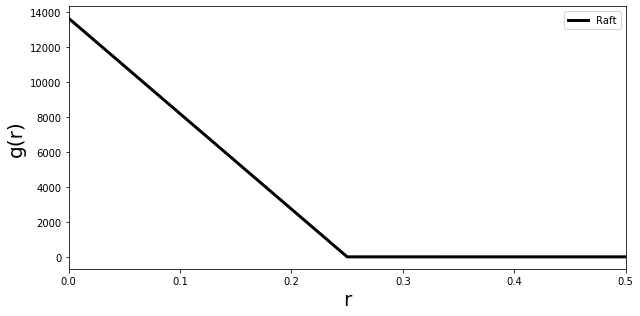

In [395]:
def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()

feature_rs = jnp.linspace(0, 1, 5)
# g = pair_correlation_fun(space.metric(distance))
symbols = np.array(symbols)
g = pair_correlation(displacement_or_metric = space.metric(space.pairwise_displacement), sigma = 1.0)
# g = pair_correlation(displacement_or_metric = space.metric(space.pairwise_displacement), radii = (positions[0]**2).sum(axis = 1)**0.5, sigma = 1.0)

pair_corr = g(positions[0], (positions[0]**2).sum(axis = 1)**0.5)
print("g(r) has shape (N, number of radii) = {}.".format(pair_corr.shape))
plt.plot(feature_rs, np.sum(pair_corr, axis=0), 'k', linewidth=3)

plt.xlabel('r', fontsize=20)
plt.ylabel('g(r)', fontsize=20)

plt.legend(['Raft'], loc='upper right')
plt.xlim([0, 0.5])

finalize_plot((1.5, 0.75))

In [396]:
pair_corr

DeviceArray([[4.4068584e+03, 3.1599178e+00, 3.3573079e+00, 2.6939509e+00,
              3.3915055e+00],
             [2.3500471e+03, 2.6282115e+00, 2.7484131e+00, 2.3397081e+00,
              2.7691367e+00],
             [2.3983293e+03, 2.6699362e+00, 2.7926867e+00, 2.3752244e+00,
              2.8138478e+00],
             [1.9664558e+03, 2.4641714e+00, 2.5671535e+00, 2.2161245e+00,
              2.5848908e+00],
             [2.5121445e+03, 2.7224648e+00, 2.8507714e+00, 2.4146564e+00,
              2.8728950e+00]], dtype=float32)

In [397]:
positions[0]

DeviceArray([[-0.0034502 ,  0.01017081,  0.01938033],
             [-0.7954868 ,  0.5766599 , -0.5472012 ],
             [-0.39378393, -0.97992676,  0.2722862 ],
             [ 0.6344988 ,  0.4473651 ,  0.93568736],
             [ 0.59581804, -0.16517928, -0.8915708 ]], dtype=float32)

In [398]:
tmp1 = (positions**2).sum(axis = 2)**0.5
tmp2 = (positions[0]**2).sum(axis = 1)**0.5

print(tmp1.shape)
print(tmp2.shape)

(5400, 5)
(5,)


In [399]:
symbols = np.array(symbols)
g = pair_correlation(displacement_or_metric = space.metric(space.pairwise_displacement),  sigma = 1.0)

In [402]:
n = len(positions)
grid_size = 10
no_training_samples = int(n * 0.75)
print('Total number of examples is {}, number of\
 training examples is {}'.format(len(positions), no_training_samples))

vectorized_g = jit(vmap(g))

train_positions = np.array(positions[:no_training_samples])
train_features = vectorized_g(train_positions, (train_positions**2).sum(axis = 2)**0.5)
test_positions = np.array(positions[no_training_samples:])
test_features = vectorized_g(test_positions, (test_positions**2).sum(axis = 2)**0.5)

# train_f_len = train_features.shape[1]
# size_diff_train = grid_size - train_f_len
# train_features = np.pad(train_features, [[0, 0], [0, size_diff_train], [0, size_diff_train]])

# test_f_len = test_features.shape[1]
# size_diff_test = grid_size - test_f_len
# test_features = np.pad(test_features, [[0, 0], [0, size_diff_test], [0, size_diff_test]])

train_energies = np.array(energies[:no_training_samples])
test_energies = np.array(energies[no_training_samples:])

Total number of examples is 5400, number of training examples is 4050


In [403]:
tmp = train_features[0] 
tmp = np.vstack((tmp, r))
tmp

DeviceArray([[4.4068584e+03, 3.1599178e+00, 3.3573079e+00, 2.6939509e+00,
              3.3915055e+00],
             [2.3500471e+03, 2.6282115e+00, 2.7484131e+00, 2.3397081e+00,
              2.7691367e+00],
             [2.3983293e+03, 2.6699362e+00, 2.7926867e+00, 2.3752244e+00,
              2.8138478e+00],
             [1.9664558e+03, 2.4641714e+00, 2.5671535e+00, 2.2161245e+00,
              2.5848908e+00],
             [2.5121445e+03, 2.7224648e+00, 2.8507714e+00, 2.4146564e+00,
              2.8728950e+00],
             [7.0000000e+01, 2.5000000e+01, 2.5000000e+01, 2.5000000e+01,
              2.5000000e+01]], dtype=float32)

In [372]:
no_hidden_units = 4
init_fun, _E = stax.serial(
    stax.Dense(no_hidden_units, ), stax.Relu,  # hidden layer 1
    stax.Dense(no_hidden_units), stax.Relu,  # hidden layer 2
    stax.Dense(1))  # readout
E = lambda params, features: _E(params, features)

In [373]:
positions[0].shape

(5, 3)

In [374]:
train_features.shape

(4050, 5, 5)

In [375]:
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
    if not iter_len:
        iter_len = len(iter_fun)
    out = display(progress(0, iter_len), display_id=True)
    for i, it in enumerate(iter_fun):
        yield it
        out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [376]:
from jax.experimental import optimizers
from random import randrange

# def initialize_new_nn(train_positions, test_positions):
    
#     no_training_samples = int(n * 0.75)
#     print('Total number of examples is {}, number of\
#      training examples is {}'.format(len(positions), no_training_samples))

#     vectorized_g = jit(vmap(g))

#     train_positions = np.array(positions[:no_training_samples])
#     train_features = vectorized_g(train_positions)
#     test_positions = np.array(positions[no_training_samples:])
#     test_features = vectorized_g(test_positions)
    
key = random.PRNGKey(5)
train_steps = 3001
print_every = 250
batch_size = 50
train_epochs = 20
import time 

training_samples = np.arange(no_training_samples)

# neural_dict = dict()

# for sym in symbols:
#     # Initialize the network.
#     key = random.PRNGKey(randrange(10))
#     key, net_key = random.split(key)
#     _, params = init_fun(net_key, (grid_size, grid_size))

#     # Create the optimizer.
#     opt_init, opt_update, get_params = optimizers.adam(1e-2)
#     state = opt_init(params)
#     neural_dict[sym] = state

# Initialize the network.
key, net_key = random.split(key)
_, params = init_fun(net_key, (grid_size, grid_size))

# Create the optimizer.
opt_init, opt_update, get_params = optimizers.adam(1e-2)
state = opt_init(params)

def loss_t(params, features, energies):
#     print(positions.shape)
#     print(features.shape)
#     print(energies.shape)
    E_per_atom_per_system = E(params, features)
    E_total = np.sum(E_per_atom_per_system, axis=(1, 2))
    print(E_per_atom_per_system.shape)
#     print("E_total: ", E_total)
#     print("energies: ", energies)
    return np.sqrt(np.mean((E_total - energies)**2)) / grid_size

def loss(params, features, energies):
#     print(positions.shape)
#     print(features.shape)
#     print(energies.shape)
    E_per_atom_per_system = E(params, features)
    E_total = np.sum(E_per_atom_per_system)
#     print("E_total: ", E_total)
#     print("energies: ", energies)
    return np.sqrt(np.mean((E_total - energies)**2)) 
grad_loss = grad(loss_t)

@jit
def update_step(state, batch):
    positions, features, energies = batch
#     print("features: ", features)
#     print("positions: ", features)
#     print("energies: ", features)
    params = get_params(state)
#     print("params: ", params)
    d_params = grad_loss(params, features, energies)
    return opt_update(0, d_params, state)


def batch(key):
    steps_per_epoch = no_training_samples // batch_size 
    train_epochs = train_steps // steps_per_epoch
    for s in range(train_epochs):
        key, split = random.split(key)
        permutation = random.shuffle(split, training_samples)
        positions = train_positions[permutation]
        features = train_features[permutation]
        energies = train_energies[permutation]
        for i in range(0, no_training_samples, batch_size):
            batch_data = (positions[permutation[i:i + batch_size]], 
                        features[permutation[i:i + batch_size]], energies[permutation[i:i + batch_size]])
            yield batch_data
            
# def batch(key):
#     for s in range(train_epochs):
#         for i in range(len(train_energies)):
#             positions = train_positions[i]
#             features = train_features[i]
#             energies = train_energies[i]

#             batch_data = (positions, features, energies)
#             yield batch_data


print('Mean predictor loss on the test set is {:5.8f}'.format
      (np.mean((test_energies - np.mean(test_energies))**2)))

# Do the training.
t = time.time()
train_losses = []
test_losses = []

for i, b in ProgressIter(enumerate(batch(key)), train_steps):
    state = update_step(state, b)

  # Print some diagnostics.
    if i and i % print_every == 0:
        dt = time.time() - t
        train_loss = loss_t(get_params(state), train_features, train_energies)
#         train_losses += [train_loss]

        test_loss = loss_t(get_params(state), test_features, test_energies)
#         test_losses += [test_loss]

        print(('Time: {:5.2f}\tStep: {:4d}\t'
               'Training-loss: {:5.8f}\tTest-loss: {:5.8f}').format(
            dt, i, train_loss, test_loss))
        t = time.time()

Mean predictor loss on the test set is 0.00018678


(50, 5, 1)
(4050, 5, 1)
(1350, 5, 1)
Time:  2.92	Step:  250	Training-loss: 11.56337929	Test-loss: 11.30482197
(4050, 5, 1)
(1350, 5, 1)
Time:  2.22	Step:  500	Training-loss: 48.43732452	Test-loss: 47.16864395
(4050, 5, 1)
(1350, 5, 1)
Time:  2.15	Step:  750	Training-loss: 73.38925171	Test-loss: 71.38740540
(4050, 5, 1)
(1350, 5, 1)
Time:  2.13	Step: 1000	Training-loss: 3.93587232	Test-loss: 3.82714534
(4050, 5, 1)
(1350, 5, 1)
Time:  2.30	Step: 1250	Training-loss: 22.81272316	Test-loss: 22.20717239
(4050, 5, 1)
(1350, 5, 1)
Time:  2.23	Step: 1500	Training-loss: 9.50074577	Test-loss: 9.24850559
(4050, 5, 1)
(1350, 5, 1)
Time:  2.20	Step: 1750	Training-loss: 4.04525518	Test-loss: 3.93596983
(4050, 5, 1)
(1350, 5, 1)
Time:  2.16	Step: 2000	Training-loss: 0.47375512	Test-loss: 0.46524405
(4050, 5, 1)
(1350, 5, 1)
Time:  2.26	Step: 2250	Training-loss: 2.21256518	Test-loss: 2.15374112
(4050, 5, 1)
(1350, 5, 1)
Time:  2.25	Step: 2500	Training-loss: 2.38345003	Test-loss: 2.31942225
(4050, 5, 1

In [245]:
positions = jax.device_put(dta[1][1])
energies = jax.device_put(dta[1][2])
symbols = dta[1][0]

energy_mean = jnp.mean(energies)
energy_std = jnp.std(energies)

print('positions.shape = {}'.format(positions.shape))
print('<E> = {}'.format(energy_mean))

box_size = 10.862
displacement, shift = space.periodic(box_size)

positions.shape = (3600, 4, 3)
<E> = -56.510860443115234


In [246]:
n = len(positions)
grid_size = 10
no_training_samples = int(n * 0.75)
print('Total number of examples is {}, number of\
 training examples is {}'.format(len(positions), no_training_samples))

vectorized_g = jit(vmap(g))

train_positions = np.array(positions[:no_training_samples])
train_features = vectorized_g(train_positions, (train_positions**2).sum(axis = 2)**0.5)
test_positions = np.array(positions[no_training_samples:])
test_features = vectorized_g(test_positions, (test_positions**2).sum(axis = 2)**0.5)

train_f_len = train_features.shape[1]
size_diff_train = grid_size - train_f_len
train_features = np.pad(train_features, [[0, 0], [0, size_diff_train], [0, size_diff_train]])

test_f_len = test_features.shape[1]
size_diff_test = grid_size - test_f_len
test_features = np.pad(test_features, [[0, 0], [0, size_diff_test], [0, size_diff_test]])

train_energies = np.array(energies[:no_training_samples])
test_energies = np.array(energies[no_training_samples:])

Total number of examples is 3600, number of training examples is 2700


In [247]:
test_energies

DeviceArray([-56.51026 , -56.52589 , -56.51382 , -56.52259 , -56.498295,
             -56.51384 , -56.520386, -56.525864, -56.526306, -56.520275,
             -56.511948, -56.51372 , -56.49219 , -56.49639 , -56.52623 ,
             -56.497444, -56.499794, -56.502884, -56.51577 , -56.494602,
             -56.517513, -56.494675, -56.52018 , -56.494244, -56.506687,
             -56.50083 , -56.52413 , -56.508217, -56.50501 , -56.50877 ,
             -56.518684, -56.511135, -56.51761 , -56.524837, -56.50281 ,
             -56.521416, -56.495064, -56.52144 , -56.501274, -56.47912 ,
             -56.509666, -56.5052  , -56.52056 , -56.503662, -56.510994,
             -56.506252, -56.517433, -56.510063, -56.49628 , -56.51766 ,
             -56.51137 , -56.502712, -56.525196, -56.498016, -56.507423,
             -56.52171 , -56.49986 , -56.514782, -56.503483, -56.524963,
             -56.523563, -56.514217, -56.52432 , -56.509212, -56.49818 ,
             -56.516335, -56.514828, -56.499714, -5

In [248]:
for i, b in ProgressIter(enumerate(batch(key)), train_steps):
    state = update_step(state, b)

  # Print some diagnostics.
    if i and i % print_every == 0:
        dt = time.time() - t
        train_loss = loss_t(get_params(state), train_features, train_energies)
#         train_losses += [train_loss]

        test_loss = loss_t(get_params(state), test_features, test_energies)
#         test_losses += [test_loss]

        print(('Time: {:5.2f}\tStep: {:4d}\t'
               'Training-loss: {:5.8f}\tTest-loss: {:5.8f}').format(
            dt, i, train_loss, test_loss))
        t = time.time()

(50, 10, 1)
(2700, 10, 1)
(900, 10, 1)
Time:  4.70	Step:  250	Training-loss: 0.00120055	Test-loss: 0.00122522
(2700, 10, 1)
(900, 10, 1)
Time:  1.91	Step:  500	Training-loss: 0.00119157	Test-loss: 0.00121590
(2700, 10, 1)
(900, 10, 1)
Time:  1.77	Step:  750	Training-loss: 0.00137728	Test-loss: 0.00140607
(2700, 10, 1)
(900, 10, 1)
Time:  2.28	Step: 1000	Training-loss: 0.00108845	Test-loss: 0.00110471
(2700, 10, 1)
(900, 10, 1)
Time:  1.85	Step: 1250	Training-loss: 0.00108886	Test-loss: 0.00110520
(2700, 10, 1)
(900, 10, 1)
Time:  1.86	Step: 1500	Training-loss: 0.00145098	Test-loss: 0.00148071
(2700, 10, 1)
(900, 10, 1)
Time:  1.79	Step: 1750	Training-loss: 0.00108962	Test-loss: 0.00109850
(2700, 10, 1)
(900, 10, 1)
Time:  1.93	Step: 2000	Training-loss: 0.00108168	Test-loss: 0.00109559
(2700, 10, 1)
(900, 10, 1)
Time:  1.97	Step: 2250	Training-loss: 0.00121258	Test-loss: 0.00123769
(2700, 10, 1)
(900, 10, 1)
Time:  2.06	Step: 2500	Training-loss: 0.00117528	Test-loss: 0.00119891
(2700, 1

In [249]:
positions = jax.device_put(dta[2][1])
energies = jax.device_put(dta[2][2])
symbols = dta[2][0]

energy_mean = jnp.mean(energies)
energy_std = jnp.std(energies)

print('positions.shape = {}'.format(positions.shape))
print('<E> = {}'.format(energy_mean))

box_size = 10.862
displacement, shift = space.periodic(box_size)

positions.shape = (1800, 3, 3)
<E> = -76.37413024902344


In [250]:
n = len(positions)
grid_size = 10
no_training_samples = int(n * 0.75)
print('Total number of examples is {}, number of\
 training examples is {}'.format(len(positions), no_training_samples))

vectorized_g = jit(vmap(g))

train_positions = np.array(positions[:no_training_samples])
train_features = vectorized_g(train_positions, (train_positions**2).sum(axis = 2)**0.5)
test_positions = np.array(positions[no_training_samples:])
test_features = vectorized_g(test_positions, (test_positions**2).sum(axis = 2)**0.5)

train_f_len = train_features.shape[1]
size_diff_train = grid_size - train_f_len
train_features = np.pad(train_features, [[0, 0], [0, size_diff_train], [0, size_diff_train]])

test_f_len = test_features.shape[1]
size_diff_test = grid_size - test_f_len
test_features = np.pad(test_features, [[0, 0], [0, size_diff_test], [0, size_diff_test]])

train_energies = np.array(energies[:no_training_samples])
test_energies = np.array(energies[no_training_samples:])

Total number of examples is 1800, number of training examples is 1350


In [251]:
for i, b in ProgressIter(enumerate(batch(key)), train_steps):
    state = update_step(state, b)

  # Print some diagnostics.
    if i and i % print_every == 0:
        dt = time.time() - t
        train_loss = loss_t(get_params(state), train_features, train_energies)
        train_losses += [train_loss]

        test_loss = loss_t(get_params(state), test_features, test_energies)
        test_losses += [test_loss]

        print(('Time: {:5.2f}\tStep: {:4d}\t'
               'Training-loss: {:5.8f}\tTest-loss: {:5.8f}').format(
            dt, i, train_loss, test_loss))
        t = time.time()

(50, 10, 1)
(1350, 10, 1)
(450, 10, 1)
Time:  4.49	Step:  250	Training-loss: 0.00091633	Test-loss: 0.00089140
(1350, 10, 1)
(450, 10, 1)
Time:  1.94	Step:  500	Training-loss: 0.00137604	Test-loss: 0.00138132
(1350, 10, 1)
(450, 10, 1)
Time:  1.93	Step:  750	Training-loss: 0.00159807	Test-loss: 0.00160906
(1350, 10, 1)
(450, 10, 1)
Time:  2.01	Step: 1000	Training-loss: 0.00088891	Test-loss: 0.00085804
(1350, 10, 1)
(450, 10, 1)
Time:  1.88	Step: 1250	Training-loss: 0.00156315	Test-loss: 0.00157339
(1350, 10, 1)
(450, 10, 1)
Time:  1.91	Step: 1500	Training-loss: 0.00087690	Test-loss: 0.00084052
(1350, 10, 1)
(450, 10, 1)
Time:  1.82	Step: 1750	Training-loss: 0.00095766	Test-loss: 0.00093860
(1350, 10, 1)
(450, 10, 1)
Time:  1.82	Step: 2000	Training-loss: 0.00087800	Test-loss: 0.00084258
(1350, 10, 1)
(450, 10, 1)
Time:  1.82	Step: 2250	Training-loss: 0.00155368	Test-loss: 0.00156371
(1350, 10, 1)
(450, 10, 1)
Time:  1.91	Step: 2500	Training-loss: 0.00123711	Test-loss: 0.00123728
(1350, 1

In [252]:
def format_plot(x, y):  
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)
    
params = get_params(state)
neural_energy_fun = lambda r: np.sum(E(params, g(r)), axis=(0, 1))

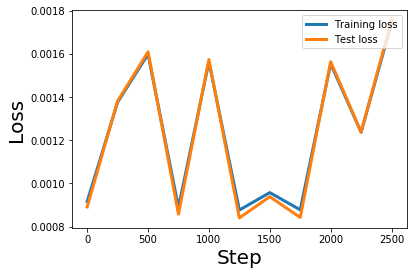

In [253]:
plt.plot()

out_steps = [x * print_every for x in range(len(train_losses))]
plt.plot(out_steps, train_losses, linewidth=3, label='Training loss')
plt.plot(out_steps, test_losses, linewidth=3, label='Test loss')
plt.legend(loc='upper right')
format_plot('Step', 'Loss')

In [254]:
from jax.experimental import optimizers
from random import randrange

# def initialize_new_nn(train_positions, test_positions):
    
#     no_training_samples = int(n * 0.75)
#     print('Total number of examples is {}, number of\
#      training examples is {}'.format(len(positions), no_training_samples))

#     vectorized_g = jit(vmap(g))

#     train_positions = np.array(positions[:no_training_samples])
#     train_features = vectorized_g(train_positions)
#     test_positions = np.array(positions[no_training_samples:])
#     test_features = vectorized_g(test_positions)
    
key = random.PRNGKey(5)
train_steps = 3001
print_every = 250
batch_size = 50
train_epochs = 20
import time 

training_samples = np.arange(no_training_samples)

# neural_dict = dict()

# for sym in symbols:
#     # Initialize the network.
#     key = random.PRNGKey(randrange(10))
#     key, net_key = random.split(key)
#     _, params = init_fun(net_key, (grid_size, grid_size))

#     # Create the optimizer.
#     opt_init, opt_update, get_params = optimizers.adam(1e-2)
#     state = opt_init(params)
#     neural_dict[sym] = state

# Initialize the network.
key, net_key = random.split(key)
_, params = init_fun(net_key, (grid_size, grid_size))

# Create the optimizer.
opt_init, opt_update, get_params = optimizers.adam(1e-2)
state = opt_init(params)

def loss_t(params, features, energies):
#     print(positions.shape)
#     print(features.shape)
#     print(energies.shape)
    E_per_atom_per_system = E(params, features)
    E_total = np.sum(E_per_atom_per_system, axis=(1, 2))
#     print("E_total: ", E_total)
#     print("energies: ", energies)
    return np.sqrt(np.mean((E_total - energies)**2)) / grid_size

def loss(params, features, energies):
#     print(positions.shape)
#     print(features.shape)
#     print(energies.shape)
    E_per_atom_per_system = E(params, features)
    E_total = np.sum(E_per_atom_per_system)
#     print("E_total: ", E_total)
#     print("energies: ", energies)
    return np.sqrt(np.mean((E_total - energies)**2)) 
grad_loss = grad(loss_t)

@jit
def update_step(state, batch):
    positions, features, energies = batch
#     print("features: ", features)
#     print("positions: ", features)
#     print("energies: ", features)
    params = get_params(state)
#     print("params: ", params)
    d_params = grad_loss(params, features, energies)
    return opt_update(0, d_params, state)


def batch(key):
    steps_per_epoch = no_training_samples // batch_size 
    train_epochs = train_steps // steps_per_epoch
    for s in range(train_epochs):
        key, split = random.split(key)
        permutation = random.shuffle(split, training_samples)
        positions = train_positions[permutation]
        features = train_features[permutation]
        energies = train_energies[permutation]
        for i in range(0, no_training_samples, batch_size):
            batch_data = (positions[permutation[i:i + batch_size]], 
                        features[permutation[i:i + batch_size]], energies[permutation[i:i + batch_size]])
            yield batch_data
            
# def batch(key):
#     for s in range(train_epochs):
#         for i in range(len(train_energies)):
#             positions = train_positions[i]
#             features = train_features[i]
#             energies = train_energies[i]

#             batch_data = (positions, features, energies)
#             yield batch_data


print('Mean predictor loss on the test set is {:5.8f}'.format
      (np.mean((test_energies - np.mean(test_energies))**2)))

# Do the training.
t = time.time()
train_losses = []
test_losses = []

for i, b in ProgressIter(enumerate(batch(key)), train_steps):
    state = update_step(state, b)

  # Print some diagnostics.
    if i and i % print_every == 0:
        dt = time.time() - t
        train_loss = loss_t(get_params(state), train_features, train_energies)
        train_losses += [train_loss]

        test_loss = loss_t(get_params(state), test_features, test_energies)
        test_losses += [test_loss]

        print(('Time: {:5.2f}\tStep: {:4d}\t'
               'Training-loss: {:5.8f}\tTest-loss: {:5.8f}').format(
            dt, i, train_loss, test_loss))
        t = time.time()

Mean predictor loss on the test set is 0.00007010


Time:  2.29	Step:  250	Training-loss: 0.04544495	Test-loss: 0.04721785
Time:  1.92	Step:  500	Training-loss: 0.00652861	Test-loss: 0.00647326
Time:  2.10	Step:  750	Training-loss: 0.00493891	Test-loss: 0.00496270
Time:  2.13	Step: 1000	Training-loss: 0.00409727	Test-loss: 0.00404224
Time:  2.07	Step: 1250	Training-loss: 0.00401457	Test-loss: 0.00405967
Time:  1.98	Step: 1500	Training-loss: 0.00346852	Test-loss: 0.00341129
Time:  2.20	Step: 1750	Training-loss: 0.00347536	Test-loss: 0.00351858
Time:  2.03	Step: 2000	Training-loss: 0.00334923	Test-loss: 0.00329471
Time:  2.00	Step: 2250	Training-loss: 0.00370086	Test-loss: 0.00373442
Time:  2.32	Step: 2500	Training-loss: 0.00249150	Test-loss: 0.00242817
Time:  2.01	Step: 2750	Training-loss: 0.00267654	Test-loss: 0.00270544


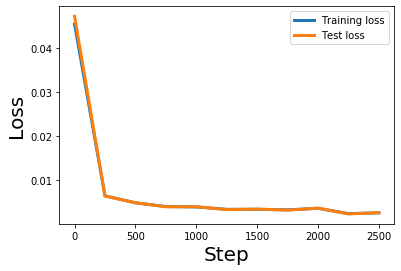

In [255]:
plt.plot()

out_steps = [x * print_every for x in range(len(train_losses))]
plt.plot(out_steps, train_losses, linewidth=3, label='Training loss')
plt.plot(out_steps, test_losses, linewidth=3, label='Test loss')
plt.legend(loc='upper right')
format_plot('Step', 'Loss')